In [1]:
# Import Libraries 

import sqlite3 as sql
import pandas as pd
import numpy as np
import datetime as dt
from scipy import stats as st
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.style
import matplotlib.dates as dtm
%matplotlib inline

matplotlib.style.use('classic')

def line():
    print('------------------------------------')

###### **Author: ** Whitney King

**Date: ** 5/15/2018

-----------------------------------------------------------------------------

## Overview

 -  The exploration is presented in Jupyter Notebook, since this is a great 
    platform for delivering code, data, and thoughts simultaneously.
 -  As a visual aid to navigating the database and writing the queries, I am using SQLiteStudio, 
    but the rest of the work is being done in Python3
 -  This exploration uses the ```sqlite3``` library to integrate a SQLite 
    client with Python3. 
     -  This will enable exploration and in depth analysis of the data in the 
        database for the hypothetical pet care company that was aquired
     -  Python has simple integration with other extremely powerful libraries 
        which could pull in this data for other processing needs in the future


In [2]:
db = 'db26.sqlite3'

# Open connection to SQLite DB, and place a cursor for traversal of data
conn = sql.connect(db)
c = conn.cursor()


## I. Exercises

**The first goal should be to dig into this data to ensure everything is in order, and the following questions are correctly answered:**
  
To help with this next step, I will be moving to SQLiteStudio initially to explore the database structure and write some queries that can answer these questions. These queries can then be called back using Python. 
 -  I think this is a good and easy to understand means of answering these simpler questions that don't require a lot of heavy lifting or analysis. 
 -  It's also portable, since it keeps the queries in their own files that can be used with other systems.

To bring the results back into Python and make them readble in Jupyter, we'll bring the query results in using Pandas dataframes.

###  1.  How many users have signed up?
  -  The answer is 64416 

In [3]:
qry1 = open('queries/explore_I1.sql', 'r').read()
out1 = c.execute(qry1).fetchall()
line()
print(qry1)
line()
print('Output: ', out1[0][0])

------------------------------------
SELECT COUNT(*)
FROM people_person
------------------------------------
Output:  64416


### 2.  How many users signed up prior to 2017-01-12 ?
  - The answer is 35500 

In [4]:
qry2 = open('queries/explore_I2.sql', 'r').read()
out2 = c.execute(qry2).fetchall()
line()
print(qry2)
line()
print('Output: ', out2[0][0])

------------------------------------
SELECT COUNT(*)
FROM people_person
WHERE date_joined < '2017-01-12'
------------------------------------
Output:  35500


### 3.  What percentage of users have added pets?
  - The answer is 80.44% 
  
In this case, since we have a count of users from the first question, we can simply get a count of pets using a second query, and divide the two counts. SQLite lacks a robust math backbone suchas a dual table for peforming divisions on table counts like this, so writing a query to divide these table counts and get the percentage is quite messy. This is much more elegant simply doing the last bit of math here in Python.

In [5]:
qry3 = open('queries/explore_I3.sql', 'r').read()
out3 = c.execute(qry3).fetchall()
line()
print(qry3)
line()
print('Output: ', out3[0][0])

pct = round(out3[0][0] / out1[0][0] * 100, 2)
print('% Users with Pets: ', pct)

------------------------------------
SELECT COUNT(count) userPets
FROM (SELECT COUNT(*) count
      FROM pets_pet
      GROUP BY owner_id) pets
------------------------------------
Output:  51816
% Users with Pets:  80.44


### 4.  Of those users, how many pets have they added on average?
  - The answer is 1.496 

In [6]:
qry4 = open('queries/explore_I4.sql', 'r').read()
out4 = c.execute(qry4).fetchall()
line()
print(qry4)
line()
print('Output: ', round(out4[0][0], 3))

------------------------------------
SELECT AVG(count) avgPets
FROM (SELECT COUNT(*) count
      FROM pets_pet
      GROUP BY owner_id) pets
------------------------------------
Output:  1.496


### 5. What percentage of pets play well with cats?
  - The answer is 24.78% 
  
We run into the same issue here with needing to divide aggragate numbers from tables to get a percentages, expect this time, we will need to generate two unique queries, since our previous count of pets was grouped by owners. 

In [7]:
qry5 = open('queries/explore_I5a.sql', 'r').read()
out5 = c.execute(qry5).fetchall()

print('Query to Count Pets that Play w/ Cats')
line()
print(qry5)
line()
print('Output: ', out5[0][0])
print()

qry6 = open('queries/explore_I5b.sql', 'r').read()
out6 = c.execute(qry6).fetchall()
print('Query to Count All Pets')
line()
print(qry6)
line()
print('Output: ', out6[0][0])

pct2 = round(out5[0][0] / out6[0][0] * 100, 2)
print()
print('% Play Well With Cats: ', pct2)

Query to Count Pets that Play w/ Cats
------------------------------------
SELECT DISTINCT COUNT(*)
FROM pets_pet
WHERE plays_cats == 1
------------------------------------
Output:  19204

Query to Count All Pets
------------------------------------
SELECT DISTINCT COUNT(*)
FROM pets_pet
------------------------------------
Output:  77512

% Play Well With Cats:  24.78


## II. Conversations and Bookings

### 1. What are the possible services and what is the average price per unit for each service type?

This is where output will begin to get a little more complicated, since we'll be looking at a key value pairs, and matrixes for output, so switching to Pandas and Numpy makes the most sense. This also has the potential to offer features in many analytical capacities down the road.

In [8]:
qry7 = open('queries/conversions_1.sql', 'r').read()
out7 = pd.DataFrame(c.execute(qry7).fetchall(), columns=('service_type',
                                                         'avg_price'))

line()
print(qry7)
line()
print('Output: ') 
display(out7)

------------------------------------
SELECT service_type, round(AVG(price),2) avgPrice
FROM services_service
GROUP BY service_type
------------------------------------
Output: 


,service_type,avg_price
0,boarding,34.51
1,day-care,27.01
2,dog-walking,21.98


The above output shows boarding with an average price per unit of 34.51, day care with 27.01, and dog walking with 21.98

### 2. How many requests have there been for each service type and what percentage of those have booked? 

The percentage of those that have booked is called booking rate.

To answer the first part of this question, we'll want a query that returns counts for services requested in each service type.

In [9]:
qry8 = open('queries/conversions_2.sql', 'r').read()
out8 = pd.DataFrame(c.execute(qry8).fetchall())

service_volumes = out8[1]

line()
print(qry8)
line()

print('Output: ')
display(out8)

------------------------------------
SELECT service_type, COUNT(c.id) service_volume
FROM services_service AS s
    INNER JOIN conversations_conversation AS c ON s.id = c.service_id
GROUP BY service_type
------------------------------------
Output: 


,0,1
0,boarding,26665
1,day-care,26362
2,dog-walking,26716


Next, to return the booking rate, we'll have to implement some similar trickery with additional queries to obtain the average of the counts. Luckily, Pandas DataFrames are well equipped to handle the math necessary on the matrixes. First, we'll return a matrix with counts of the number of bookings for each service, then we'll divide that by the number of total requests to get the booking rate.

In [10]:
qry9 = open('queries/conversions_2b.sql', 'r').read()
out9 = pd.DataFrame(c.execute(qry9).fetchall())

booked_count = out9[1]

line()
print(qry9)
line()
print()
print('Output: ')
display(out9)

out9[1] = round(booked_count / service_volumes * 100, 2)

print()
print('Output with Booking %')
display(out9)

------------------------------------
SELECT service_type, COUNT(booked_at) booked_count
FROM services_service AS s
    INNER JOIN conversations_conversation AS c ON s.id = c.service_id
GROUP BY service_type;
------------------------------------

Output: 


,0,1
0,boarding,10862
1,day-care,9417
2,dog-walking,12811



Output with Booking %


,0,1
0,boarding,40.74
1,day-care,35.72
2,dog-walking,47.95


### 3. What are the cancellation rates for each service?

We can reuse a very similar query to what was used for booking rates to calculate the cancellation rates

In [47]:
qry10 = open('queries/conversions_2c.sql', 'r').read()
out10 = pd.DataFrame(c.execute(qry10).fetchall())

cancelled_count = out10[1]

line()
print(qry10)
line()
print()
print('Output:')
display(out10)

out10[1] = round(cancelled_count / service_volumes * 100, 2)

print()
print('Output with Cancel %')
display(out10)

------------------------------------
SELECT service_type, COUNT(cancelled_at) cancelled_count
FROM services_service AS s
    INNER JOIN conversations_conversation AS c ON s.id = c.service_id
GROUP BY service_type;
------------------------------------

Output:


,0,1
0,boarding,1051
1,day-care,919
2,dog-walking,1218



Output with Cancel %


,0,1
0,boarding,3.94
1,day-care,3.49
2,dog-walking,4.56


### 4. For uncancelled bookings, is the owner or provider more likely to leave a review and which tends to leave better reviews? 

How would you narrate this finding to a business partner?

This question calls for a little more analytical heavy lifting, and for a data geek and almost always be best explained by implementing a few little libraries. In this case, we can start where we've been, by bringing the data in via SQLite and a dataframe, and then diving into a little further with what's included with it's processing functionality to help figured out the answer.


In [48]:
qry11 = open('queries/conversions_3.sql', 'r').read()
out11 = pd.DataFrame(c.execute(qry11).fetchall(), 
                     columns = ('rating', 'reviewer_id', 'person'))

line()
print(qry11)
line()
print()
print('Preview: \n')
display(out11.head())

------------------------------------
SELECT r.stars AS rating,
       COUNT(reviewer_id), 
       CASE WHEN reviewer_id < (SELECT MAX(provider_id)
                                FROM services_service AS s) 
       THEN 'provider' ELSE 'owner' END AS person
FROM conversations_review AS r
    JOIN people_person AS p ON p.id = r.reviewer_id
        JOIN conversations_conversation AS c ON c.id = r.conversation_id
WHERE c.booked_at IS NOT NULL 
    AND c.cancelled_at IS NULL -- Service booked and not cancelled
GROUP BY person, r.stars
------------------------------------

Preview: 



,rating,reviewer_id,person
0,1,1368,owner
1,2,1359,owner
2,3,1246,owner
3,4,1324,owner
4,5,17196,owner


In [49]:
# Displays Counts of Reviews for each level of Rating, split by owner and provider
pvt = out11.pivot(index='rating', columns='person', values='reviewer_id')
display(pvt)

# Create features that will be used for the bulk of analysis
pvt['review_total'] = pvt['owner'] + pvt['provider']
pvt['owner_pct'] = round(pvt['owner'] / pvt['review_total'], 2)
pvt['provider_pct'] = round(pvt['provider'] / pvt['review_total'], 2)

# Final output with more informative columns
display(pvt)

# Sanity Check Total Reviews Against SQL Query
total_reviews = int(np.sum(out11[['reviewer_id']]))
display('Total Reviews: ', total_reviews)

person,owner,provider
rating,,
1,1368,683
2,1359,673
3,1246,651
4,1324,680
5,17196,3356


person,owner,provider,review_total,owner_pct,provider_pct
rating,,,,,
1,1368,683,2051,0.67,0.33
2,1359,673,2032,0.67,0.33
3,1246,651,1897,0.66,0.34
4,1324,680,2004,0.66,0.34
5,17196,3356,20552,0.84,0.16


'Total Reviews: '

28536

Overall this final table lets us narrate the story as needed. In every rating category, owners are more likely to leave reviews than providers, with at least two thirds of reviews being left my owners for each level. This changes however for expecially positive experiences. For 5 star ratings, owners are even more likely to take an extra bit of effort to leave a review, as 84% of review in this category were left from owners. This shows good service can really pay off in the long run with word-of-mouth marketing for providers.

## III. Recent Daily Booking Rate



Given the scenario that a junior analyst has a snapshot of this database from 2017-07-11 at midnight, and it only contains data prior that that time they appear concerned that booking rates are on a downward trend. 

First, let's reproduce their results. They tell you that daily booking rate is defined to be the percentage of conversations created each day that eventually book. 

### 1. What is the daily booking rate for each of the 90 days prior to the snapshot? Is there a downward trend?

To answer this question, I will first write two SQL queries, and then use them to bring the data into this notebook for further processing and analysis.

In [50]:
# SQL Query to get 90 Day Requested Window of Booking Counts
qry12 = open('queries/booking_1.sql', 'r').read()
out12 = c.execute(qry12).fetchall()
line()
print(qry12)
line()
print('Output: ', out12[0][0])

bookings = pd.DataFrame(out12, columns=('booked_date', 
                                        'booked_month',
                                        'booked_count'))
display(bookings.head())
display(bookings.tail())

------------------------------------
SELECT DATE(c.booked_at) AS booked_date
     , STRFTIME('%m', DATE(c.booked_at)) AS booked_month
     , COUNT(DATE(c.booked_at)) AS booked_count
FROM conversations_conversation AS c
WHERE c.booked_at BETWEEN '2017-04-12' AND '2017-07-11' -- 90 Day Snapshot of BOOKINGS
GROUP BY DATE(c.booked_at)
ORDER BY DATE(c.booked_at) ASC

------------------------------------
Output:  2017-04-12


,booked_date,booked_month,booked_count
0,2017-04-12,04,89
1,2017-04-13,04,103
2,2017-04-14,04,100
3,2017-04-15,04,91
4,2017-04-16,04,98


,booked_date,booked_month,booked_count
85,2017-07-06,07,124
86,2017-07-07,07,149
87,2017-07-08,07,123
88,2017-07-09,07,142
89,2017-07-10,07,130


In [51]:
# SQL Query to get 90 Day Requested Window of Conversation Counts
qry13 = open('queries/booking_2.sql', 'r').read()
out13 = c.execute(qry13).fetchall()
line()
print(qry13)
line()
print('Output: ', out13[0][0])

conversations = pd.DataFrame(out13, columns=('conv_date',
                                             'conv_count'))
display(conversations.head())
display(conversations.tail())


------------------------------------
SELECT DATE(cc.added) AS conversation_date, COUNT(cc.added) AS conversation_count
FROM conversations_conversation AS cc
WHERE cc.added BETWEEN '2017-04-12' AND '2017-07-11'
GROUP BY DATE(cc.added)
ORDER BY DATE(cc.added) ASC

------------------------------------
Output:  2017-04-12


,conv_date,conv_count
0,2017-04-12,213
1,2017-04-13,226
2,2017-04-14,213
3,2017-04-15,213
4,2017-04-16,206


,conv_date,conv_count
85,2017-07-06,269
86,2017-07-07,278
87,2017-07-08,274
88,2017-07-09,320
89,2017-07-10,290


Now that both types of counting based on the dates are done, these data frames can be merged and the rest of the analysis should be relatively simple. Since we're working with dates and counts, this dataset is a great candidate for a graph to make the most of the explaination.

,booked_date,booked_month,booked_count,conv_count,daily_booking_rate
0,2017-04-12,04,89,213,0.417840
1,2017-04-13,04,103,226,0.455752
2,2017-04-14,04,100,213,0.469484
3,2017-04-15,04,91,213,0.427230
4,2017-04-16,04,98,206,0.475728


,booked_date,booked_month,booked_count,conv_count,daily_booking_rate
85,2017-07-06,07,124,269,0.460967
86,2017-07-07,07,149,278,0.535971
87,2017-07-08,07,123,274,0.448905
88,2017-07-09,07,142,320,0.443750
89,2017-07-10,07,130,290,0.448276


count    90.000000
mean      0.439374
std       0.048275
min       0.309623
25%       0.408618
50%       0.442443
75%       0.469684
max       0.565854
Name: daily_booking_rate, dtype: float64

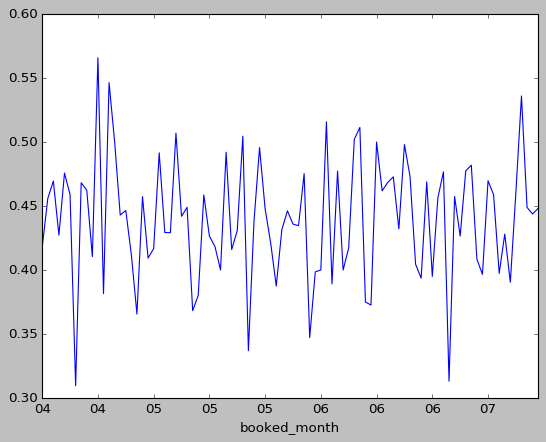

In [52]:
# Analyis completed based on booked_at date
# conv_date and conv_count were generated based on the date conversation was added

bookings['conv_count'] = conversations['conv_count']
bookings['daily_booking_rate'] = bookings['booked_count'] / bookings['conv_count']

display(bookings.head())
display(bookings.tail())

plt.clf()
bookings.set_index('booked_month')['daily_booking_rate'].plot()

display(bookings['daily_booking_rate'].describe())


**If you correctly query and join the data, there is not a downward trend. **

### 2. Can you narrate a reason why this trend exists? Is there a reason to be concerned?

However; **in the event that you invert the sort order between the values for conv_count and booked_count** (i.e. flip one to acsending and the other to decending) before putting them together will present a steep upward or downward trend to the daily booking rate data. In reality this looks pretty chaotic on this above graph, but averages a lot more flat around a solid 44% over time, with some good days and bad days here and there. This doesn't flag any reasons to be concerned.

,booked_date,booked_month,booked_count,conv_count,daily_booking_rate
0,2017-04-12,04,130,213,0.610329
1,2017-04-13,04,142,226,0.628319
2,2017-04-14,04,123,213,0.577465
3,2017-04-15,04,149,213,0.699531
4,2017-04-16,04,124,206,0.601942


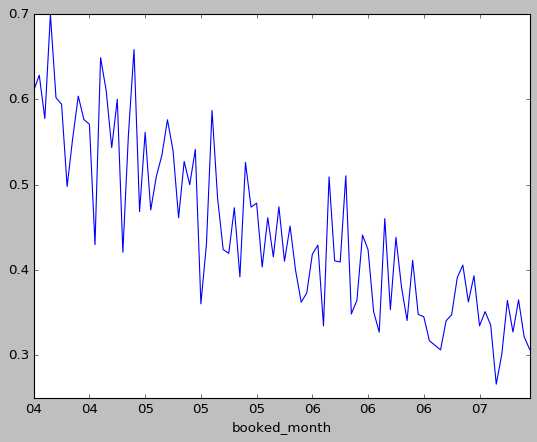

In [53]:
#  Included example of inverted queries showing incorrect downward trend to data.

bookings2 = bookings
booked_count = np.array(bookings2['booked_count'])

# Invert sort order of booked_count
booked_count = booked_count[::-1]

bookings2['booked_count'] = booked_count
bookings2['daily_booking_rate'] = bookings2['booked_count'] / bookings2['conv_count']

display(bookings2.head())

plt.clf()
bookings2.set_index('booked_month')['daily_booking_rate'].plot()

## IV. Analyzing Take Rate

To make the most sense of the fee structure, I translated the table to a query to bring tha data into a DataFrame, and we can being to tackle the questions set fourth from there

Amount Description

 - Booking Total \$100 e.g., 4 walks at $25/walk

 - Owner Fee \$5 5% of the booking total

 - Gross Billings \$105 charged to the owner

 - Service Fee \$15 15% of the booking total

 - Net Revenue \$20 all fees that go to the company

 - Provider Payment \$85 earnings for the provider

In [54]:
qry16 = open('queries/take_rate_1.sql', 'r').read()
out16 = c.execute(qry16).fetchall()
line()
print(qry16)
line()

take_rate = pd.DataFrame(out16, columns=('service_id',
                                         'booked_at',
                                         'day',
                                         'month',
                                         'year',
                                         'booking_total',
                                         'owner_fee',
                                         'gross_billings',
                                         'service_fee',
                                         'net_revenue',
                                         'provider_payment'))

# Create Dateime formatted column for timeseries
dates = []
i = 0
for i in range(0, len(take_rate)):
    dates.append(dt.datetime(int(take_rate['year'][i]),
                             int(take_rate['month'][i]),
                             int(take_rate['day'][i])))
    i +=1

    
take_rate['dates'] = dates
take_rate['index'] = take_rate.index
take_rate['year_month'] = take_rate['year'] + take_rate['month']

------------------------------------
SELECT s.id AS service_id
    , CAST(STRFTIME('%Y%m%d', DATE(booked_at)) AS INT) AS booked_at
    , STRFTIME('%d', DATE(booked_at)) AS day
    , STRFTIME('%m', DATE(booked_at)) AS month
    , STRFTIME('%Y', DATE(booked_at)) AS year
    , booking_total
    , (booking_total * p.fee) AS owner_fee
    , (booking_total + p.fee) AS gross_billings
    , (booking_total * s.fee) AS service_fee
    , (booking_total * p.fee) + (booking_total * s.fee) AS net_revenue
    , (booking_total + p.fee) - (p.fee + s.fee) AS provider_payment
FROM conversations_conversation AS c
    JOIN services_service AS s ON s.id = c.service_id
        JOIN people_person AS p on p.id = c.requester_id
WHERE booked_at IS NOT NULL
ORDER BY booked_at
------------------------------------


### 1. In each month, what were the gross billings and net revenue?

,gross_billings,net_revenue
year_month,,
201507,1035.10,175.95
201508,11900.08,2022.83
201509,20163.36,3427.37
201510,39265.30,6674.37
201511,41208.18,7004.51
201512,63393.41,11748.01
201601,79096.99,15364.87
201602,90735.79,17790.00
201603,135872.65,26728.96


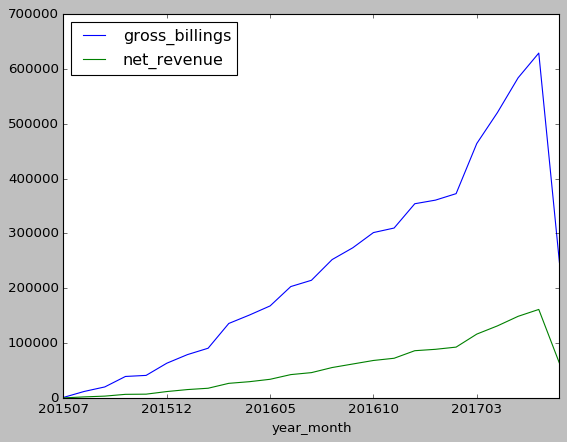

In [55]:
# Monthly Gross Billings and Net Revenue
tr1 = take_rate[['year_month', 'gross_billings', 'net_revenue']].groupby('year_month', as_index=True).sum()

display(tr1)
tr1.plot()

It's worth nothing that data for the months of July 2017 is incomplete, so the steep drop off at the end of this graph isn't anything to be alarmed about. If this were to be used for presentation purposes, more time would be spent cleaning it up, but this is just for a quick glance at the overall monthly numbers requested to answer the question.

### 2. In each month, what was the aggregate take rate?

Define take rate to be the percentage of gross billings that is net revenue. 

,year_month,take_rate
0,201507,0.169970
1,201508,0.169968
2,201509,0.169970
3,201510,0.169969
4,201511,0.169964
5,201512,0.185130
6,201601,0.194386
7,201602,0.195900
8,201603,0.196780
9,201604,0.196890


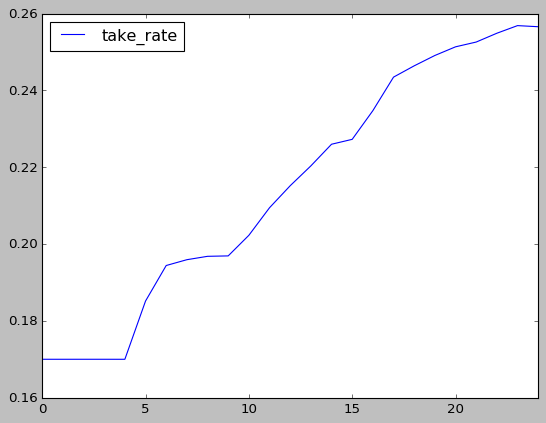

In [56]:
# Define new column to hold take_rate percentage
take_rate['take_rate'] = take_rate['net_revenue'] / take_rate['gross_billings']

# Monthly Aggregated Take Rate
tr2 = take_rate[['year', 'year_month', 'take_rate']].groupby(['year_month'], as_index=False).mean()
display(tr2)

# Plot is just a quick draw using Matplotlib
# Axis and Labels are not set or scaled
# X-Axis starts earlier than data
#   - data begins at upward point of inflection
# Included to show obvious upwards trend
tr2.plot()

### 3. Did take rate trend up or trend down or remain unchanged over time?

This is best solved with linear regression, and will make a more interesting graph without aggregating take_rate by month. We'll use a little bit of Numpy and Matplotlib along the way for this part of the project, as well as Seaborn, which is a great plotting companion library to Matplotlib

In [57]:
# Index of Take Rate per Service ID, Sorted in Ascending order
tr3 = pd.DataFrame()

tr3['index'] = tr2.index
tr3['take_rate'] = tr2['take_rate']

display(len(tr3))
display(tr3.head())

25

,index,take_rate
0,0,0.169970
1,1,0.169968
2,2,0.169970
3,3,0.169969
4,4,0.169964


To visualize the trend in take_rate over time, we will treat booked_at as X values on our axis, and take_rate as Y values on the axis. In order to fit the values to an axis, they will need to be reshaped and fit to a linear  model.  Each (x, y) pair represents a booked service_id

In [58]:
tr_data = np.array(tr3)

# Reshapes the data into the same format that can be plotted on an x, y axis
print(tr_data.shape)

# Create X and Y values for each column of data
x = tr_data[:,0].astype(dtype=int)
y = tr_data[:,1]

dates = np.array(dates).astype(dtype=np.datetime64)

# Show the differences in the data transformations
print(take_rate['dates'].head())
print(tr_data[:5])

(25, 2)
0   2015-07-20
1   2015-07-21
2   2015-07-21
3   2015-07-29
4   2015-07-30
Name: dates, dtype: datetime64[ns]
[[ 0.          0.16997011]
 [ 1.          0.1699676 ]
 [ 2.          0.16997004]
 [ 3.          0.16996933]
 [ 4.          0.16996449]]


Linear Equation:  
0.004259 x + 0.1635
------------------------------------
Monthly Take Rate Gain: 0.43%


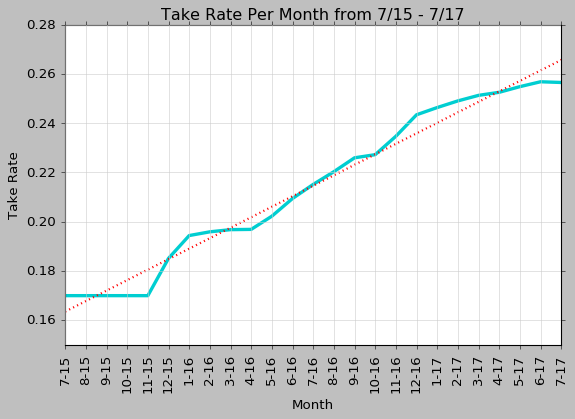

In [59]:
# Build the Linear Model
# This will ensure the datetime and take_rate are normalized on the same scale

def linear_model(x, y, d):
    z = np.polyfit(x, y, d) # Increasing d would result in a polynominal
    fx = np.poly1d(z)
    # Creates the min/max x values to plot function of(x) for regression
    xx = np.linspace(x.min(),x.max() * 10, 100, dtype=int)
    return z, fx, xx

z, fx, xx = linear_model(x, y, 1)

mx = round(z[0] * 100, 2) # Scale for % gain/month
# Equation Representing Linear Model
print('Linear Equation: %s' % fx)
line()
print('Monthly Take Rate Gain: {0}%'.format(mx))

plt.clf()
fig, ax = plt.subplots(figsize=(8,5))

# Chart friendly month labels
date_ticks = ['7-15', '8-15', '9-15', '10-15','11-15', '12-15', '1-16', 
              '2-16', '3-16', '4-16', '5-16','6-16', '7-16', '8-16',
              '9-16','10-16', '11-16', '12-16', '1-17', '2-17', '3-17', 
              '4-17','5-17', '6-17', '7-17']

plt.grid(False, linestyle='-', color='.8')
plt.title('Take Rate Per Month from 7/15 - 7/17')
plt.xlabel('Month')
plt.ylabel('Take Rate')
plt.xlim(xmax=xx.max()/10)
plt.ylim(ymin=.15, ymax=.28)
# Math is separated from labeling since dates were simply treated as sequential indexes
# for the purposes of a time series
plt.xticks([m for m in range(len(tr_data))],
           ['%s' % m for m in date_ticks],
           color='black',
           rotation='vertical')
plt.tick_params(direction='out',
               length=4)
plt.plot(x, y, c='DarkTurquoise',
         linewidth=3)
plt.plot(xx, fx(xx), ':r',
         linewidth=2)

Now we can see the linear model at work showing the upward trend in take rate over time. In general the take rate climbs steadily. Based on this, it seems there is a healthy fee structure in place. During the window of this dataset, the average take rate has increased from just below 17%, to just shy of 25%. When the dataset is scaled on a monthly basis using linear regression, that's about a .43% increase in take rate month over month.

It's worth noting this could be done a lot more elegantly with fewer lines of code and more built in functions or additional libraries, but it felt more appropriate to do this in long form for this exercise to demonstrate my thought process. Either way, you can always get a lot more out of your graphs when you manually tweak them to be the way you want. This one is by no means ready for large scale presentation, and has a lot way to go as far as visual cleanup is concerned.

## V. New Conversation Flow

**Experiment Overview**

This platform had a conversation page where owners and service providers could exchange messages as they organized their booking. The team thought this page could use a re-design and set out to improve its UI. A product manager then set up a test to measure the new page's effectiveness. On 2017-03-13 , an A/B test was launched. 

 - For those owners who sent a request, they would be randomly assigned to variant or holdout groups. 
 - Those users who are in the **variant** group would see the *new* conversation flow. 
 - Those in the **holdout** group would see the *old* conversation flow.

### 1. Did conversations with the new conversation page book at a higher rate?

I'm going to start at the end and get a general sense of the outcome of the experiment by bringing in data that will quickly summarize the answer to this question. From there we can start running a statistical analysis on if these findings are signficant.

In [60]:
qry17 = open('queries/convflow_2.sql', 'r').read()
out17 = c.execute(qry17).fetchall()
line()
print(qry17)
line()

ab_bookings = pd.DataFrame(out17, columns=('test_group', 
                                           'conv_total',
                                           'booked_total'))

ab_bookings['booking_rate'] = ab_bookings['booked_total'] / ab_bookings['conv_total']

display(ab_bookings)

# Get total sample sizes for experiment, each test group, and holdout/variant counts within each test group
sample_size = ab_bookings['conv_total'].sum()
print('Sample Size: %i' % sample_size)

------------------------------------
SELECT ts.test_group AS test_group,
       COUNT(c.id) conv_total,
       COUNT(c.booked_at) booked_total
FROM conversations_conversation AS c
        JOIN people_testsegmentation AS ts ON ts.id = c.requester_id
WHERE DATE(c.added) > '2017-03-13'
GROUP BY ts.test_group
------------------------------------


,test_group,conv_total,booked_total,booking_rate
0,holdout,1600,683,0.426875
1,variant,552,240,0.434783


Sample Size: 2152


### 2. Is it statistically significant?

To understand if the results of the test are statistically significant, we need to figure out the probability of the experiment results occuring by chance (or the p value, which represents a percentage).  The evaluation metric that will be used to measure the statistical significance is the **booking_rate**. When it comes to p-values, a low score represents statistical significance and that the results were unlikely to have occured by chance.

 - The **null hypothesis (H0)** would *not* expect to see a statistically significant difference between the **variant** and **holdout** groups
 - The **hypothesis (H1)**  *would* expect to see a statistically significant difference between the **variant** and **holdout** groups

In this case, the level of significance will be set at the traditional level of 95%, with an alpha of .05. If p < .05, we reject the null hypothesis (H0) and deem the results statistically significant. If p > .05, the results of the experiment are not statistically significant, and we reject the alternative hypothesis (H1)

Beginning with the standard deviation of the booking_rate, and some baselines Additionally, I might use some numpy and scipy for processing because they are excellent tools for making this kind of exerecise extremely efficient, but I am going to mostly rely on mathmatical formulas for the sake of demonstrating understanding.

In [61]:
import warnings
warnings.filterwarnings('ignore')

qry18 = open('queries/convflow_1.sql', 'r').read()
out18 = c.execute(qry18).fetchall()
line()
print(qry18)
line()

ab_bookings2 = pd.DataFrame(out18, columns=('conv_id', 
                                            'conv_date', 
                                            'is_booked',
                                            'test_group'))

# Drop columns with unused metrics
ab_bookings2 = ab_bookings2[['conv_date', 'test_group', 'is_booked']]

# Split data into groups
holdout = ab_bookings2.loc[ab_bookings2['test_group'].isin(['holdout'])]
variant = ab_bookings2.loc[ab_bookings2['test_group'].isin(['variant'])]
holdout['is_booked'] = pd.DataFrame(holdout['is_booked'].astype(dtype=int))
variant['is_booked'] = pd.DataFrame(variant['is_booked'].astype(dtype=int))

print('Sample Size:  %i' % (len(variant) + len(holdout)))

------------------------------------
SELECT c.id AS conv,
       DATE(c.added) AS conv_date,
       CASE WHEN c.booked_at IS NULL 
            THEN '0' 
            ELSE '1' END AS is_booked,
       ts.test_group
FROM conversations_conversation AS c 
        JOIN people_testsegmentation AS ts ON ts.id = c.requester_id
WHERE DATE(c.added) > '2017-03-13'
------------------------------------
Sample Size:  2152


In [62]:
h0 = 'The changes to the conversation flow will have no significant impact on booking rate'
h1 = 'The changes to the conversation flow will have a significant impact on booking rates'

h_stats = pd.DataFrame(holdout['is_booked'].agg(['mean', 'std', 'var', 'sem']))
v_stats = pd.DataFrame(variant['is_booked'].agg(['mean', 'std', 'var', 'sem']))
h = np.array(h_stats['is_booked'])
v = np.array(v_stats['is_booked'])

x = np.array(holdout['is_booked'])
y = np.array(variant['is_booked'])

# % of time difference will be detected when one doesn't exist 
# Significance threshhold for p value
alpha = .05 

# Recreate variables to make formulas more legible
# Mean
h_mean = h[0]
v_mean = v[0]

# Standard Deviation
h_std = h[1]
v_std = v[1]

# Variance
h_var = h[2]
v_var = v[2]

# Standard Error
h_sem = h[3]
v_sem = v[3]

# Confidence Interval
h_ci = np.array(st.t.interval(1-alpha, len(h)-1, 
                              loc=h_mean, scale=h_sem))
v_ci = np.array(st.t.interval(1-alpha, len(v)-1, 
                              loc=v_mean, scale=v_sem))
h = np.append(h, h_ci)
v = np.append(v, v_ci)

_stats = pd.DataFrame(index=['mean', 'std', 'var', 
                             'sem', 'ci_low', 'ci_high'])
_stats['holdout'] = h
_stats['variant'] = v

display(_stats)
line()

# Standard Deviation
std = (h_std + v_std) / 2
print('Standard Deviation: +- %f' % std)
line()

# t-Statistic and p value for independent sample sets
t, p = st.ttest_ind(x, y, equal_var=False)
print('t-Statistic: %f' % t)
line()
print('p-value: {0}'.format(p))

,holdout,variant
mean,0.426875,0.434783
std,0.494778,0.496178
var,0.244806,0.246193
sem,0.012369,0.021119
ci_low,0.387510,0.367573
ci_high,0.466240,0.501992


------------------------------------
Standard Deviation: +- 0.495478
------------------------------------
t-Statistic: -0.323095
------------------------------------
p-value: 0.7466941458489214


In [63]:
# Test Experiment Outcome
print('a = %.2f' % alpha)
print('p = %.4f' % p)

def test_results():
    if p <= alpha:
        return '<=', '', 'reject', 'accept', 'H1', h1
    else:
        return '>', 'in', 'accept', 'reject', 'H0', h0

test = test_results()

line()
print('p %s a' % test[0])
print()
print('Results were statistically {0}significant'.format(test[1]))
print('Recommend to {0} H0, and {1} H1'.format(test[2], test[3]))
line()
print()
print('{0}: {1}'.format(test[4], test[5]))

a = 0.05
p = 0.7467
------------------------------------
p > a

Results were statistically insignificant
Recommend to accept H0, and reject H1
------------------------------------

H0: The changes to the conversation flow will have no significant impact on booking rate


The above bit of code does a sanity check to validate the results of the t_test run on the experiment samples to indicate directly which hypothesis should be rejected, and which should be accepted. This should help give a clear indication of how to to proceed with this particular experiment, or if it should be rethought out. In this case, the experiment wasn't successful, so it would be advisable to consider other options that might make a more significant impact.

When graphed on a box plot there almost no difference between the two sets of descriptive statistics, so it's not so hard to visually see how there wasn't a significant difference between the sets according to the test.

,holdout,variant
min,0.012369,0.021119
25%,0.280482,0.276538
50%,0.407192,0.401178
75%,0.456399,0.480829
max,0.494778,0.501992


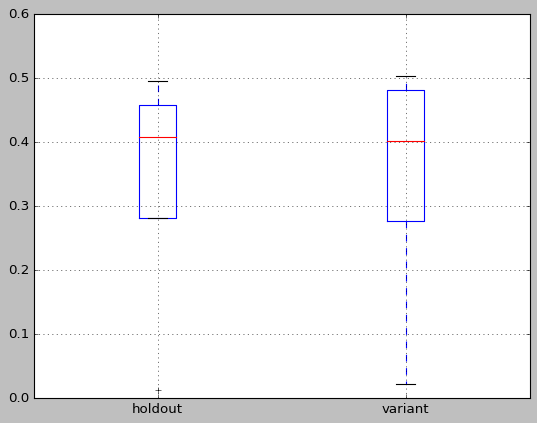

In [64]:
# Generate Boxplot Stats
h_bp = pd.DataFrame(h, columns=(['holdout'])).describe()
v_bp = pd.DataFrame(v, columns=(['variant'])).describe()

bp = pd.DataFrame(index=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
bp['holdout'] = h_bp
bp['variant'] = v_bp

bp = bp.iloc[3:]
display(bp)

bp.boxplot()

### 3. Do you have any reservations about the experiment design? What would you recommend as next steps?

In general, the experiment had enough to get by, however it was extremely limited in how it was setup. By setting users to either variant or holdout groups, you basically have to wait for the users randomly flagged to strike up a conversation to get counted. This has an element of randomness, but isn't truely random, since when you really dive into the data, some users in both the holdover and variant groups had more than one conversation. This also impacted the frequency of when variant data tended to be collected.

 Maybe this isn't such a huge problem in the grand scheme of things, but it seems like something to think about when something like a unique cookie could be used. This would be one of my primary recommendations moving forward, especially for a web based service. Overall, I would suggest to run this experiment again, but with a between element of randomness that does a better job spreading out when the data is collected, and doesn't keep it tied to person_id.

## VI. Search Engine Marketing

Historically, this company spent an average of \$30 per account to advertise in the 2nd position on Google. However, on 2017-04-12, they decided to start bidding for the 1st position. Since 2017-04-12 , they have spent \$210285 in total.

### 1. For each day, determine the count of users that joined and were acquired through Google. 

Plot this and confirm there is an inflection point on or near 2017-04-12

------------------------------------
SELECT DATE(date_joined) AS date_joined
     , COUNT(p.id) AS users_joined
FROM people_person AS p
WHERE p.channel = 'Google'
GROUP BY DATE(date_joined)
ORDER BY date_joined
------------------------------------


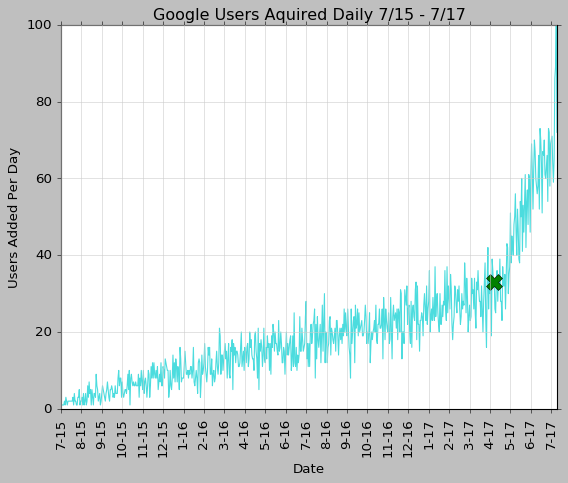

In [65]:
qry19 = open('queries/google_1.sql', 'r').read()
out19 = c.execute(qry19).fetchall()
line()
print(qry19)
line()

google = pd.DataFrame(out19, columns=('date_joined', 
                                      'users_joined'))

google['index'] = google.index
infl = np.array(google.loc[google['date_joined'] =='2017-04-12'])

plt.clf()
plt.grid(False, linestyle='-', color='.8')
plt.title('Google Users Aquired Daily 7/15 - 7/17')
plt.xlabel('Date')
plt.ylabel('Users Added Per Day')

# Math is separated from labeling since dates were simply treated as sequential indexes
# for the purposes of a time series
plt.xticks([m*29 for m in range(len(google))],
           ['%s' % m for m in date_ticks],
           color='black',
           rotation='vertical')
plt.tick_params(direction='out',
               length=4)
plt.plot(google['index'], google['users_joined'], c='DarkTurquoise',
         linewidth=1,
         alpha=.7)
plt.plot(infl[0][2],infl[0][1],
         marker='X',
         markersize=15,
         color='g')

### 2. How many users were acquired via Google advertising since 2017-04-12 and what was the average cost per account?

In [66]:
ms = 210285

old_google = google.loc[google['date_joined'] < '2017-04-12']
new_google = google.loc[google['date_joined'] >= '2017-04-12']

nu_sum = new_google['users_joined'].sum()
print('New Users: %i' % nu_sum)
line()

nu_avg_cost = ms / nu_sum
print('New Users Avg. Cost: $%.2f' % nu_avg_cost)

New Users: 4673
------------------------------------
New Users Avg. Cost: $45.00


### 3. Estimate how many users would have been acquired had the company not changed its bidding strategy. What would have been the marketing spend in that case?

For this part, I am going to return to my old friend regression, but since I built the previous model specifically around the other demonstration, I am going to do this the quick way and use the stats.LinearRegress() function to get the numbers needed to proceed

(0, 100)

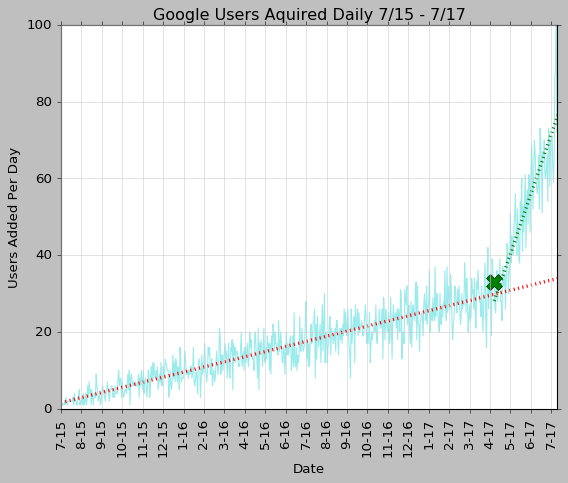

In [67]:
ox = old_google['index']
oy = old_google['users_joined']
nx = new_google['index']
ny = new_google['users_joined']

# Reuse the handy linear model function we built earlier
oz, ofx, oxx = linear_model(ox, oy, 1)
nz, nfx, nxx = linear_model(nx, ny, 1)

plt.clf()

plt.title('Google Users Aquired Daily 7/15 - 7/17')
plt.xlabel('Date')
plt.ylabel('Users Added Per Day')
# Math is separated from labeling since dates were simply treated as sequential indexes
# for the purposes of a time series
plt.xticks([m*29 for m in range(len(google))],
           ['%s' % m for m in date_ticks],
           color='black',
           rotation='vertical')
plt.tick_params(direction='out',
               length=4)
plt.grid(False, linestyle='-', color='.8')
plt.plot(google['index'], google['users_joined'], c='DarkTurquoise',
         linewidth=1,
         alpha=.4)
plt.plot(infl[0][2],infl[0][1],
         marker='X',
         markersize=15,
         color='g')
plt.plot(oxx, ofx(oxx),
         ':r', linewidth=3)
plt.plot(nxx, nfx(nxx),
         ':g', linewidth=3)
plt.xlim(xmin=oxx.min(), xmax=nxx.max()/10)
plt.ylim(ymin=0, ymax=100)

In [68]:
ou_avg_cost = 30
td = nx.max() - ox.max()

o_avg = oy.mean()
n_avg = ny.mean()

# Averages for each set of users
print('Average Old Users Added Per Day: {0:.2f}'.format(o_avg))
print('Average New Users Added Per Day: {0:.2f}'.format(n_avg))
line()
print()

o_growth = oz[0] * 100
n_growth = nz[0] * 100

# Growth in Avg Old-New Users per day, pre new ads
print('Daily Growth in Avg Old Users Added: {0:.2f}'.format(o_growth))

# Growth in Avg New-New Users per day, post new ads
print('Daily Growth in Avg New Users Added: {0:.2f}'.format(n_growth))
line()
print()

# Create function to estimate growth to average over the time delta
def estimate_growth(avg, growth):
    for i in range(0, td):
        avg = avg + growth # Not working in percentages
    return avg

ou_est = estimate_growth(o_avg, o_growth)
nu_est = estimate_growth(o_avg, n_growth) # Avg starting point from 4/12

ms_est = ou_est * ou_avg_cost
    
print('Estimated New Users/Old Model > 4/12/2017: {0:.0f}'.format(ou_est))
print('Estimated Marketing Spend: ${0:.2f}'. format(ms_est))

Average Old Users Added Per Day: 15.68
Average New Users Added Per Day: 51.92
------------------------------------

Daily Growth in Avg Old Users Added: 4.59
Daily Growth in Avg New Users Added: 53.57
------------------------------------

Estimated New Users/Old Model > 4/12/2017: 429
Estimated Marketing Spend: $12859.22


It's worth noting that it's highly unlikely we'd continue to see the current trend the linear model the new data set is showing, and at some point it would taper off and stablize at a less ferverant growth rate when the bulk of the campaign winds down, or critical mass is hit.

### 4. How many additional accounts were created? What was the marginal cost per account for these additional accounts?

Marginal costs can be calculated as the changes in total cost over the changes in quantity.

In [69]:
n_added = int(nu_sum - ou_est)
msd = ms - ms_est

print('Additional Marketing Spend: ${0:.2f}'.format(msd))
print('Additional Accounts With New Ads: {0}'. format(n_added))
line()
marg_cost = msd / n_added
print('Marginal Cost Per New Account: ${0:.2f}'.format(marg_cost))

Additional Marketing Spend: $197425.78
Additional Accounts With New Ads: 4244
------------------------------------
Marginal Cost Per New Account: $46.52
